<a href="https://colab.research.google.com/github/MdAbuRummanRefat/FacialSentimentAnalysis/blob/main/SentimentAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#!pip install tensorflow==1.7.0
#!pip install keras==2.1.5

In [ ]:
import tensorflow
tensorflow.__version__

'2.3.0'

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
data=pd.read_csv('/content/drive/My Drive/Project/fer2013.csv')
data.head(5)

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [ ]:
labels = {0: 'Angry', 1: 'Digust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
emotion_counts = data['emotion'].value_counts().reset_index()
emotion_counts.columns = ['emotion', 'number']
emotion_counts['emotion'] = emotion_counts['emotion'].map(labels)
emotion_counts

,emotion,number
0,Happy,8989
1,Neutral,6198
2,Sad,6077
3,Fear,5121
4,Angry,4953
5,Surprise,4002
6,Digust,547


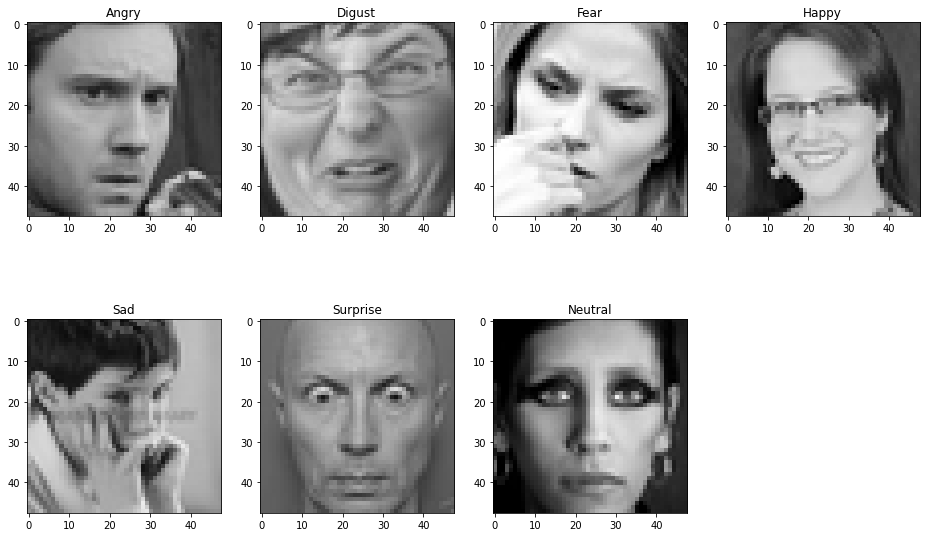

In [ ]:
def row2image(row):
    pixels, emotion = row['pixels'], labels[row['emotion']]
    img = np.array(pixels.split())
    img = img.reshape(48,48)
    image = np.zeros((48,48,3))
    image[:,:,0] = img
    image[:,:,1] = img
    image[:,:,2] = img
    return np.array([image.astype(np.uint8), emotion])

plt.figure(0, figsize=(16,10))
for i in range(1,8):
    face = data[data['emotion'] == i-1].iloc[0]
    img = row2image(face)
    plt.subplot(2,4,i)
    plt.imshow(img[0])
    plt.title(img[1])

plt.show()

In [ ]:
data_train = data[data['Usage']=='Training'].copy()
data_val   = data[data['Usage']=='PublicTest'].copy()
data_test  = data[data['Usage']=='PrivateTest'].copy()

In [ ]:
from keras.utils import to_categorical
def pre_Processing(data):
    temp = data.pixels.apply(lambda row: [float(p) for p in row.split()])
    X = np.array(temp.tolist())
    X = X.reshape(-1,1,48,48)
    X = X/255.0
    Y = to_categorical(data['emotion'], len(labels)) 
    return X,Y

X_train,y_train = pre_Processing(data_train)
X_test,y_test = pre_Processing(data_test)
X_val,y_val = pre_Processing(data_val)

In [ ]:
X_train=X_train/255.0
X_val=X_val/255.0
X_test=X_test/255.0
print(np.shape(X_train))
print(np.shape(X_val))
print(np.shape(X_test))

(28709, 1, 48, 48)
(3589, 1, 48, 48)
(3589, 1, 48, 48)


In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import BatchNormalization
from keras.layers import MaxPooling2D
from keras.layers import Activation
from keras.optimizers import SGD , Adam,Adamax
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Dense
from keras.regularizers import l2
from keras import backend as K
K.set_image_data_format('channels_first')
#K.set_image_dim_ordering('th')
reg=0.0002
channel_dimension=1
classes=7

model=Sequential()

model.add(Conv2D(64, (3, 3), input_shape=(1,48,48), padding="same", kernel_regularizer=l2(reg)))
model.add(Activation("relu"))
model.add(Conv2D(64, (3, 3), padding="same", kernel_regularizer=l2(reg)))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=channel_dimension))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.35))

model.add(Conv2D(128, (3, 3), padding="same", kernel_regularizer=l2(reg)))
model.add(Activation("relu"))
model.add(Conv2D(128, (3, 3), padding="same", kernel_regularizer=l2(reg)))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=channel_dimension))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.35))

    
model.add(Conv2D(256, (3, 3), dilation_rate=(2, 2),padding="same", kernel_regularizer=l2(reg)))
model.add(Activation("relu"))
model.add(Conv2D(256, (3, 3), padding="valid", kernel_regularizer=l2(reg)))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=channel_dimension))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.35))


model.add(Conv2D(512, (3, 3),dilation_rate=(2, 2), padding="same", kernel_regularizer=l2(reg)))
model.add(Activation("relu"))
model.add(Conv2D(512, (3, 3), padding="valid", kernel_regularizer=l2(reg)))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=channel_dimension))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.35))
        

model.add(Flatten())
model.add(Dense(64, kernel_regularizer=l2(reg)))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=channel_dimension))
model.add(Dropout(0.35))

model.add(Dense(classes, kernel_regularizer=l2(reg)))
model.add(Activation("softmax"))


model.compile(loss='binary_crossentropy',
              optimizer=Adam(lr=.001) ,
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 48, 48)        640       
_________________________________________________________________
activation (Activation)      (None, 64, 48, 48)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 48, 48)        36928     
_________________________________________________________________
activation_1 (Activation)    (None, 64, 48, 48)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 48, 48)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 24, 24)        0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 24, 24)        0

In [ ]:
batch_size = 64
epochs = 200

model.compile(loss='binary_crossentropy',
              optimizer=Adam(lr=.001) ,
              metrics=['accuracy'])
steps_per_epoch =len(X_train) // batch_size
validation_steps = len((X_val, y_val)) // batch_size

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
# data generator
datagen = ImageDataGenerator(
        featurewise_center=False,  
        samplewise_center=False,  
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False,  
        rotation_range=10,  
        zoom_range = 0.0,  
        width_shift_range=0.1,  
        height_shift_range=0.1,  
        horizontal_flip=False, 
        vertical_flip=False)  
datagen.fit(X_train)

In [ ]:

from keras.callbacks import CSVLogger, ModelCheckpoint, EarlyStopping
from keras.callbacks import ReduceLROnPlateau

lr_reduce = ReduceLROnPlateau(monitor='val_accuracy',patience=3, factor=0.5,
                              verbose=1,min_lr=.000005,epsilon=0.0005, )

In [ ]:
history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),
                    steps_per_epoch=len(X_train) // batch_size,
                    callbacks=[lr_reduce],
                    validation_data=(X_val, y_val),
                    epochs = epochs, verbose = 2)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/200
448/448 - 20s - loss: 0.7189 - accuracy: 0.2311 - val_loss: 0.4395 - val_accuracy: 0.1301
Epoch 2/200
448/448 - 20s - loss: 0.4182 - accuracy: 0.2498 - val_loss: 0.4159 - val_accuracy: 0.2494
Epoch 3/200
448/448 - 20s - loss: 0.4124 - accuracy: 0.2716 - val_loss: 0.4420 - val_accuracy: 0.2494
Epoch 4/200
448/448 - 20s - loss: 0.4134 - accuracy: 0.2945 - val_loss: 0.5578 - val_accuracy: 0.1301
Epoch 5/200

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0024999999441206455.
448/448 - 20s - loss: 0.4103 - accuracy: 0.3064 - val_loss: 1.6004 - val_accuracy: 0.1301
Epoch 6/200
448/448 - 20s - loss: 0.3896 - accuracy: 0.3510 - val_loss: 0.5231 - val_accuracy: 0.2494
Epoch 7/200
448/448 - 20s - loss: 0.3878 - accuracy: 0.3700 - val_loss: 1.1490 - val_accuracy: 0.1301
Epoch 8/200

Epoch 00008: ReduceLROnPlateau reducing learning rate to 0.0012499999720603228.
448/448 - 20s - loss: 0.3874 - accur

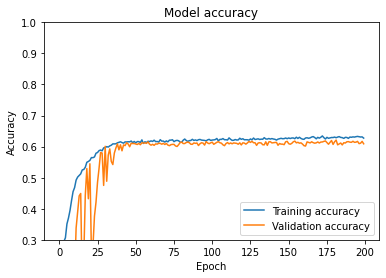

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylim(.3, 1.0)
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training accuracy', 'Validation accuracy'], loc='lower right')
plt.show()

In [ ]:
model.evaluate(X_val,y_val)

113/113 [==============================] - 1s 8ms/step - loss: 0.2620 - accuracy: 0.6091


[0.2619786858558655, 0.6090832948684692]

In [ ]:
model.evaluate(X_test,y_test)

113/113 [==============================] - 1s 8ms/step - loss: 0.2544 - accuracy: 0.6169


[0.25442585349082947, 0.6168849468231201]

In [ ]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(X_test, batch_size=batch_size)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)
from sklearn.metrics import classification_report
target_names =["Angry", "Disgust","Fear","Happy","Sad","Surprise","Neutral"]
print(classification_report(y_test.argmax(axis=1),
                            predIdxs, target_names=target_names))

[INFO] evaluating network...
              precision    recall  f1-score   support

       Angry       0.55      0.54      0.54       491
     Disgust       0.50      0.02      0.04        55
        Fear       0.48      0.34      0.40       528
       Happy       0.83      0.86      0.85       879
         Sad       0.47      0.44      0.45       594
    Surprise       0.71      0.75      0.73       416
     Neutral       0.53      0.70      0.60       626

    accuracy                           0.62      3589
   macro avg       0.58      0.52      0.52      3589
weighted avg       0.61      0.62      0.61      3589

